## Analysis notebook for atmosphere NetCDF files

### Define utils

In [1]:
import numpy as np
import netCDF4 as nc
from copy import deepcopy
import glob
import os
from scipy.interpolate import PchipInterpolator

import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
import matplotlib.pyplot as plt

import pandas as pd
from cmcrameri import cm


In [2]:
from proteus.config import read_config
from proteus.utils.plot import observer_bands
import utils.load_grid as lg

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# %matplotlib widget

In [4]:
def readrun(f, stride=1):
    print("Reading files in '%s'..." % f)
    ncdfs = glob.glob(f+"/data/*_atm.nc")
    if len(ncdfs) == 0:
        raise Exception("No files found!")

    years = [float(s.split("/")[-1].split("_")[0]) for s in ncdfs]

    if stride < 0:
        mask = [np.argsort(years)[-1]]
    else:
        mask = np.argsort(years)[::int(stride)]

    ncdfs = np.array([ncdfs[i] for i in mask])
    years = np.array([years[i] for i in mask])
    data  = np.array([lg.readncdf(f) for f in ncdfs])

    print("    Done reading %d files" % len(years))
    print("    Final time = %1.3e years" % years[-1])
    return years, data

def read_helpfile(fpath):
    return pd.read_csv(fpath, sep=r'\s+')



### Do analysis

In [5]:
# pltname = "hd63433d"
# outname = "article_data/mnras_proteus_agni/hd63433d_oxfu/"
# title = "HD 63433 d"

pltname = "trappist1c"
outname = "article_data/mnras_proteus_agni/trappist1c_oxfu/"
title = "TRAPPIST-1 c"

stride = 10

In [6]:
globber = os.path.join(os.environ.get("HOME"),"analysis/data/",outname) + "/case_*/"
print(globber)
cases = glob.glob(globber)

npoints = len(cases)
print("npoints = %d"%npoints)
if npoints < 1:
    raise

data = []
help = []
conf = []
post = []
for folder in cases:
    y,d = readrun(folder, stride=stride)
    data.append( (y,d) )
    conf.append( read_config(folder+"init_coupler.toml") )
    help.append( read_helpfile(folder+"runtime_helpfile.csv") )
print("Done")

/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu//case_*/
npoints = 22
Reading files in '/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu/case_00000/'...
    Done reading 22 files
    Final time = 7.140e+05 years
Reading files in '/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu/case_00001/'...
    Done reading 22 files
    Final time = 8.409e+05 years
Reading files in '/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu/case_00002/'...
    Done reading 22 files
    Final time = 1.167e+06 years
Reading files in '/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu/case_00003/'...
    Done reading 22 files
    Final time = 1.541e+06 years
Reading files in '/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu/case_00004/'...
    Done reading 22 files
    Final time = 2.181e+06 years
Reading files in '/home/n/nicholl

## Plot flux and meltfrac vs time

In [77]:
indep_var = "outgas.fO2_shift_IW"
indep_lbl = r"log$_{10}$ (fO$_{2}$ / IW)"

indep_vals = set()
for i in range(npoints):
    indep_vals.add(lg.descend_get(conf[i],indep_var))

indep_max = np.amax(np.abs(list(indep_vals)))
indep_unique = np.unique(list(indep_vals))


In [78]:
print(indep_unique)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


In [79]:
cmap = cm.batlow
norm = mpl.colors.Normalize(vmin=-indep_max, vmax=indep_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

In [86]:
def add_cbar(fig, ticks=[], tick_format="%+d"):
    fig.subplots_adjust(right=0.89)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax, values=sorted(indep_vals))
    cbar.set_label(indep_lbl)

    if len(ticks) > 1:
        cbar.set_ticks(ticks=ticks, labels=[tick_format%t for t in ticks])

def make_legend(ax, loc='best', lw=1.0):

    leg = ax.legend(loc=loc)

    # Remove duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    leg = ax.legend(by_label.values(), by_label.keys(), loc=loc)

    for hdl in leg.legend_handles:
        hdl.set_color('k')

    for line in leg.get_lines():
        line.set_linewidth(lw)

    return leg


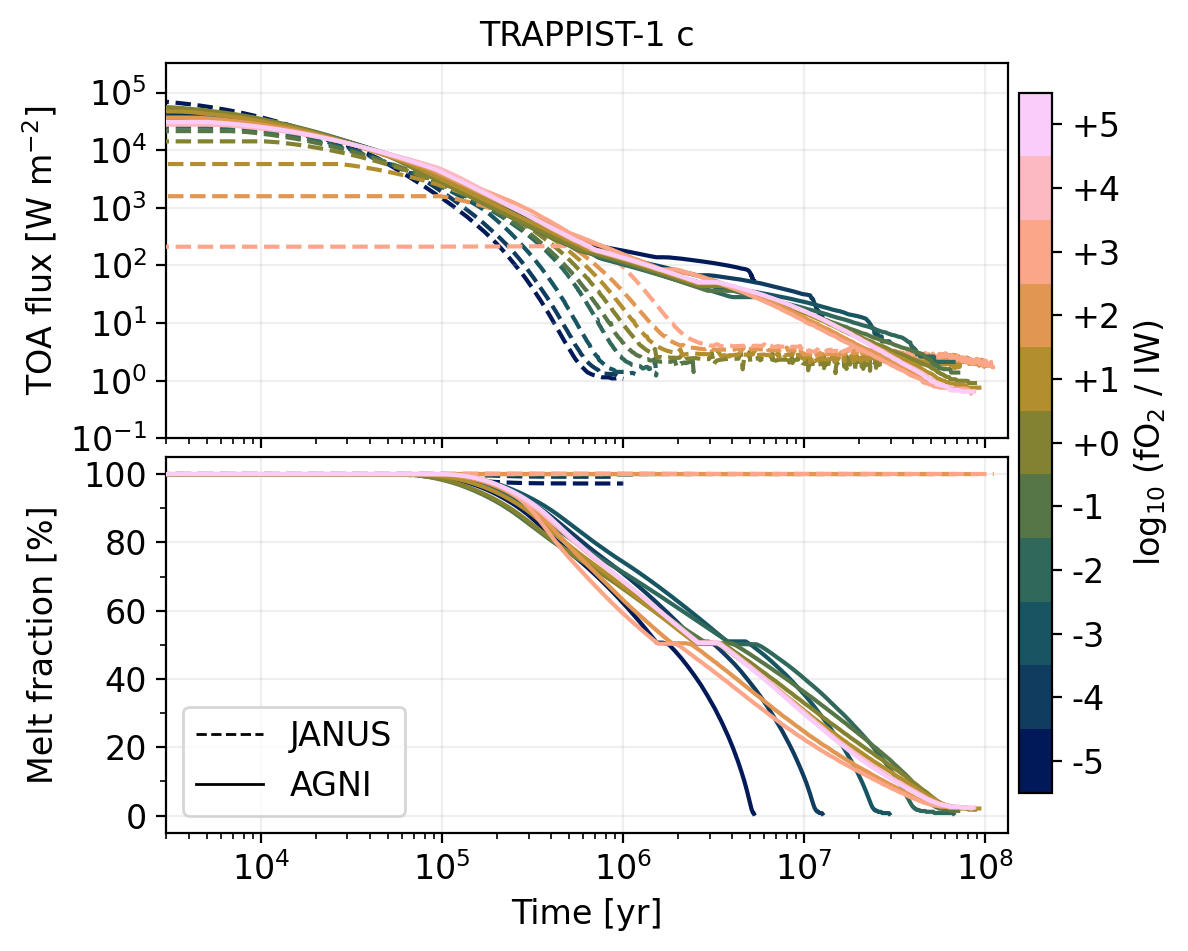

In [87]:
fig,(ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(5.5,5))

crop = -1

xmin = 3e3
xmax = xmin+1
for i in range(npoints):
    col = sm.to_rgba(float(lg.descend_get(conf[i],indep_var)))

    ls = 'solid'
    lbl = 'AGNI'
    if lg.descend_get(conf[i],"atmos_clim.module") == "janus":
        ls='dashed'
        lbl = "JANUS"

    x1 = help[i]["Time"][0:crop]
    y1 = np.array(help[i]["F_atm"][0:crop])
    ax1.plot(x1,y1,linestyle=ls, c=col, zorder=i)
    xmax = max(xmax, np.amax(x1))

    x2 = help[i]["Time"][0:crop]
    y2 = np.array(help[i]["Phi_global"][0:crop]) * 1e2
    ax2.plot(x2,y2,linestyle=ls, c=col, zorder=i, label=lbl)
    xmax = max(xmax, np.amax(x2))

add_cbar(fig, ticks=indep_unique)
make_legend(ax2)

ax1.set_title(title, fontsize=12)
ax1.set_xscale("log")
ax1.set_xlim(left=xmin, right=xmax*1.2)
ax1.grid(zorder=-2, alpha=0.2)
ax2.grid(zorder=-2, alpha=0.2)
ax2.set_xlabel("Time [yr]")

ax1.set_yscale("log")
ax1.set_ylabel(r"TOA flux [W m$^{-2}$]")
ax1.set_ylim(bottom=0.1)
ax1.yaxis.set_major_locator(LogLocator(numticks=100))

ax2.set_ylim(top=105, bottom=-5)
ax2.set_ylabel('Melt fraction [%]')
ax2.yaxis.set_major_locator(MultipleLocator(20))
ax2.yaxis.set_minor_locator(MultipleLocator(10))

fig.align_ylabels()
fig.subplots_adjust(hspace=0.05)
plt.show()

for fmt in ["png","pdf"]:
    fig.savefig("output/agni_v_janus/%s/evolve.%s"%(pltname,fmt),bbox_inches='tight', dpi=300)

## Plot scalar quantities

In [88]:
def plot_scalar_quantities(yd, show_xlabel=True):
    fig,ax = plt.subplots(1,1, sharex=True, figsize=(6,2))

    ms = 50

    x_vals = []

    for i in range(npoints):
        x = float(lg.descend_get(conf[i],indep_var))
        dat = data[i][1][0]
        y = help[i][yd["key"]].iloc[-1]

        col = sm.to_rgba(x)
        marker = 's'
        lbl = "AGNI"
        if lg.descend_get(conf[i],"atmos_clim.module") == "janus":
            marker = 'o'
            lbl = "JANUS"

        ax.scatter(x,y*yd["scl"], marker=marker, color=col, edgecolors="k",
                    s=ms, label=lbl, zorder=2)

        x_vals.append(x)

    if show_xlabel:
        ax.set_xlabel(indep_lbl)
    ax.set_ylabel(yd["lbl"])
    ax.set_xticks(np.unique(x_vals))
    if len(yd["loc"]) == 2:
        ax.set_ylim(yd["loc"])
    ax.set_title(title, fontsize=12)

    make_legend(ax, loc='center right')
    ax.grid(zorder=-2, alpha=0.2)

    plt.show()

    for fmt in ["png","pdf"]:
        fig.savefig("output/agni_v_janus/%s/%s.%s"%(pltname,yd["key"],fmt),bbox_inches='tight', dpi=300)


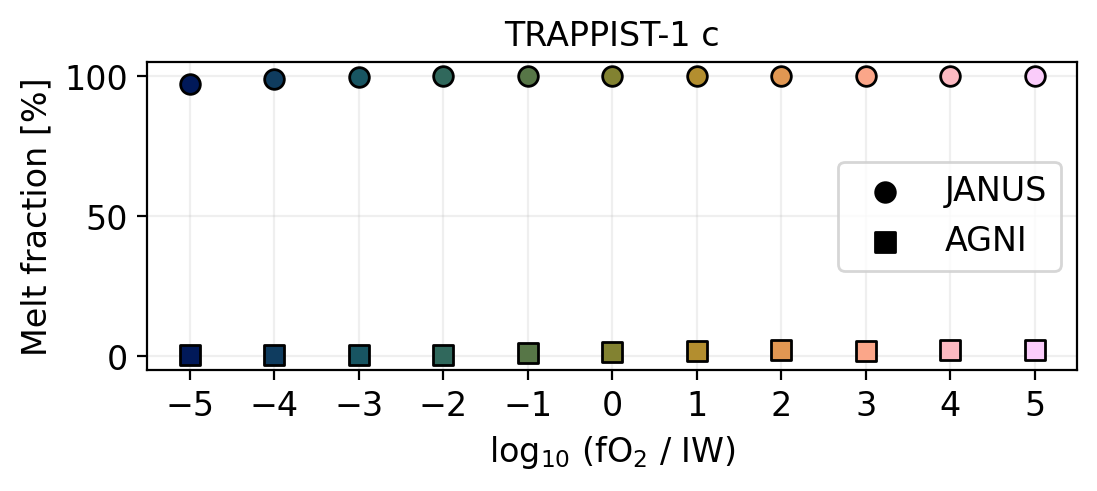

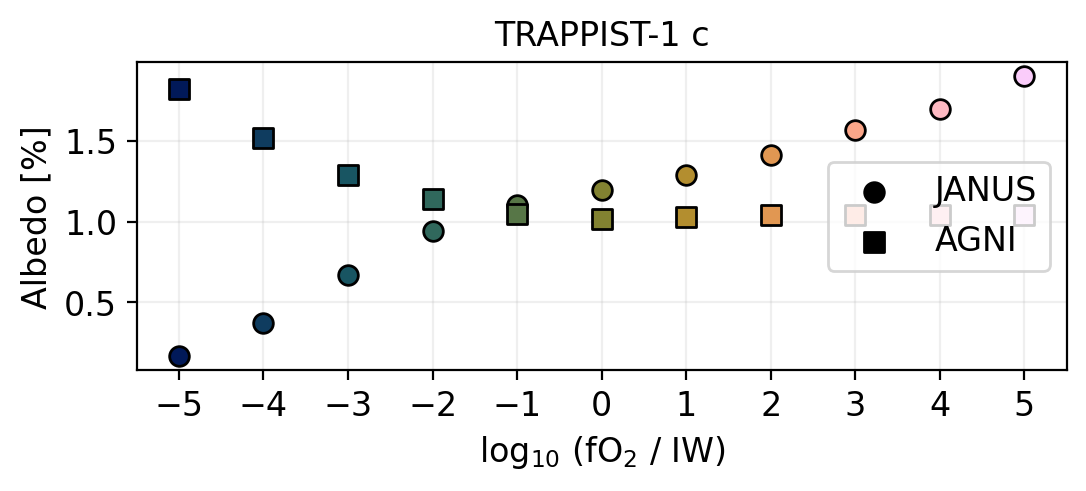

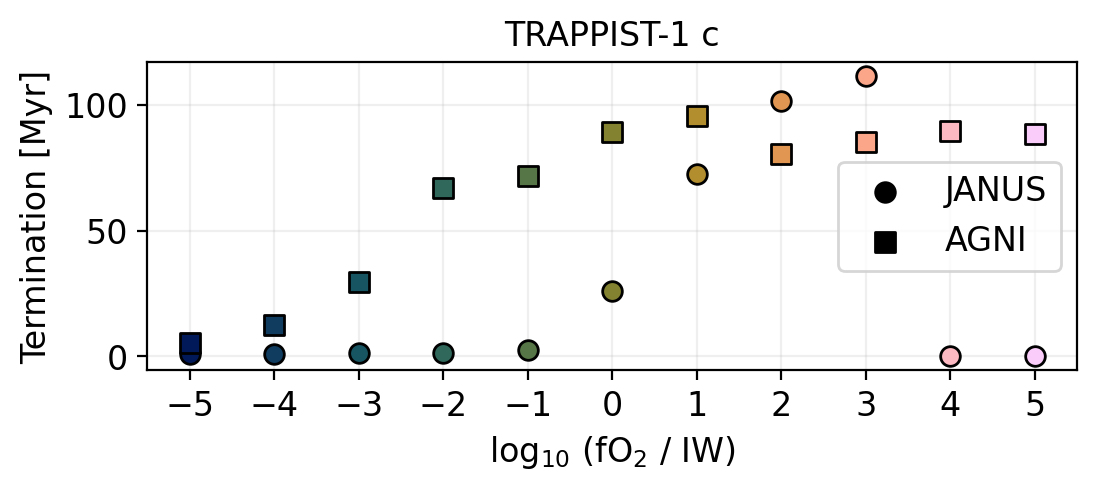

In [90]:
show_xlabel = True

yd = {
    "lbl" : "Melt fraction [%]",
    "key" : "Phi_global",
    "scl" : 100.0,
    "loc" : [-5,105],
}
plot_scalar_quantities(yd, show_xlabel=show_xlabel)

yd = {
    "lbl" : "Albedo [%]",
    "key" : "bond_albedo",
    "scl" : 100.0,
    "loc" : [],
}
plot_scalar_quantities(yd, show_xlabel=show_xlabel)


yd = {
    "lbl" : "Termination [Myr]",
    "key" : "Time",
    "scl" : 1e-6,
    "loc" : [],
}
plot_scalar_quantities(yd, show_xlabel=show_xlabel)

## Plot T(p) at endpoint

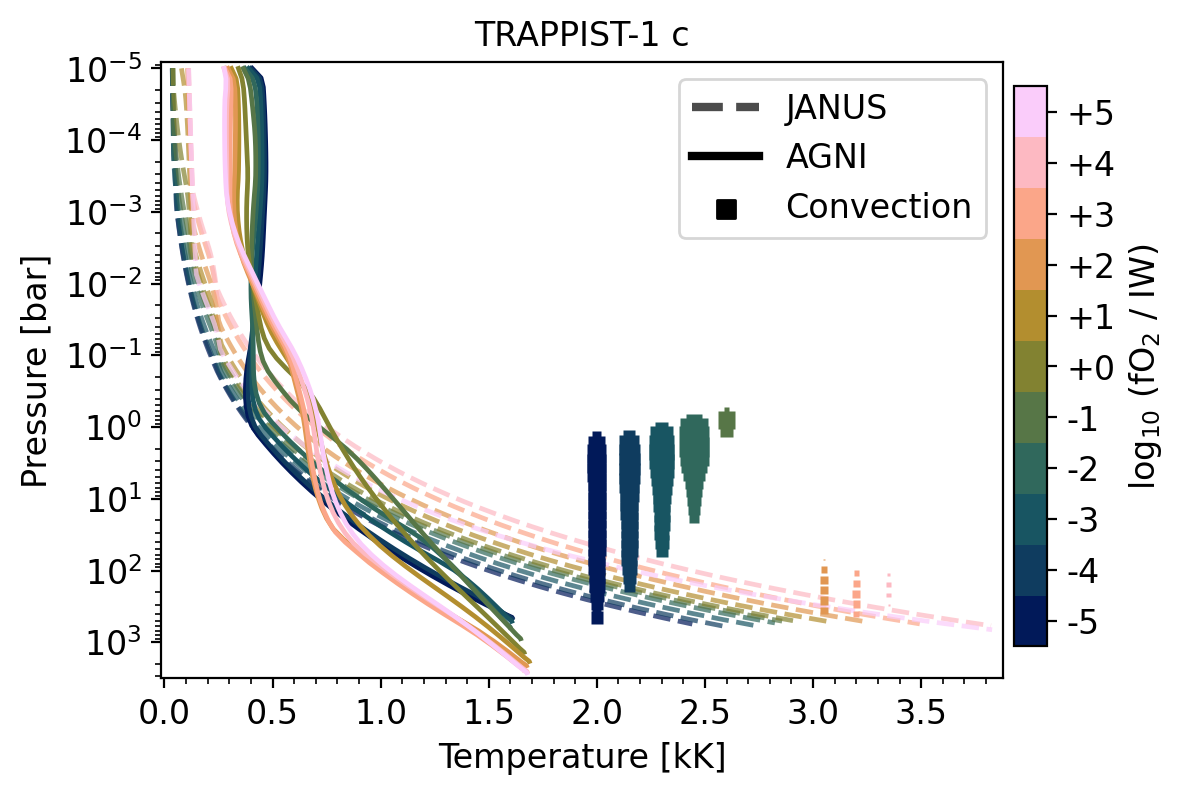

In [97]:
fig,ax = plt.subplots(1,1, sharex=True, figsize=(5.5,4))

janus_alpha = 0.7

ymin = 1; ymax = 10
xmin = 1.0; xmax = 1.5
lw = 1.7
idx = -1
agni_i = -1

smax = 40

for i in range(npoints):
    yrs = data[i][0]
    dat = data[i][1]

    col = sm.to_rgba(float(lg.descend_get(conf[i],indep_var)))
    ls = 'solid'
    lbl = 'AGNI'
    al = 1.0
    if lg.descend_get(conf[i],"atmos_clim.module") == "janus":
        lbl = "JANUS"
        ls='dashed'
        mask = []
        al = janus_alpha
    else:
        agni_i += 1
        convect = np.abs(dat[idx]["fl_cnvct"] / dat[idx]["fl_tot"])
        mask = np.argwhere(convect > 1.0e-9)

    # plot temperature profile
    x = dat[idx]["tmpl"] / 1e3
    y = dat[idx]["pl"] * 1e-5
    ax.plot(x,y,label=lbl, linestyle=ls, c=col, zorder=i, lw=lw, alpha=al)

    ymax = max(ymax, np.amax(y))
    ymin = min(ymin, np.amin(y))
    xmax = max(xmax, np.amax(x))
    xmin = min(xmin, np.amin(x))

    # plot convection as scatter points
    if len(mask) >= 2:
        y = y[mask]
        x = np.ones(np.shape(y))*0.15*agni_i+2
        sarr = convect[mask] * smax
        ax.scatter(x,y, color=col, zorder=i, s=sarr, marker='s', edgecolors=(0,0,0,0))

# add scatter points to legend
ax.scatter(-1,-1,s=smax, c='k', marker='s', label="Convection")


add_cbar(fig, ticks=indep_unique)
ax.set_title(title, fontsize=12)

leg = make_legend(ax, lw=3.0)
ax.set_xlabel("Temperature [kK]")

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlim(left=xmin-0.05, right=xmax+0.05)

ax.set_ylim(top=ymin/1.2, bottom=ymax*1.2)
ax.set_yscale("log")
ax.set_ylabel('Pressure [bar]')

plt.show()

for fmt in ["png","pdf"]:
    fig.savefig("output/agni_v_janus/%s/profiles.%s"%(pltname,fmt),bbox_inches='tight', dpi=300)

## Plot field over time

In [92]:
field = "fl_cnvct"

In [93]:
# work out which indicies we want
idxs_plot = []
for i in range(npoints):
    if lg.descend_get(conf[i],"atmos_clim.module") == "agni":
        idxs_plot.append(i)
indep_vals = [lg.descend_get(conf[i],indep_var) for i in idxs_plot]
mask = np.argsort(indep_vals)
idxs_plot = [idxs_plot[i] for i in mask]
print("Cases:",idxs_plot)

Cases: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [94]:
z_all = []
for i in idxs_plot:
    dat = data[i][1]
    for j in range(len(dat)):
        val = np.abs(dat[j][field])
    z_all.extend(list(val))

zmax = np.percentile(z_all, 99.9)
print(zmax)

63.443664625525415


In [95]:
conv_cmap = deepcopy(cm.devon_r)
conv_cmap.set_under((1,1,1,0))

conv_norm = mpl.colors.Normalize(vmin=0, vmax=zmax)
conv_sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

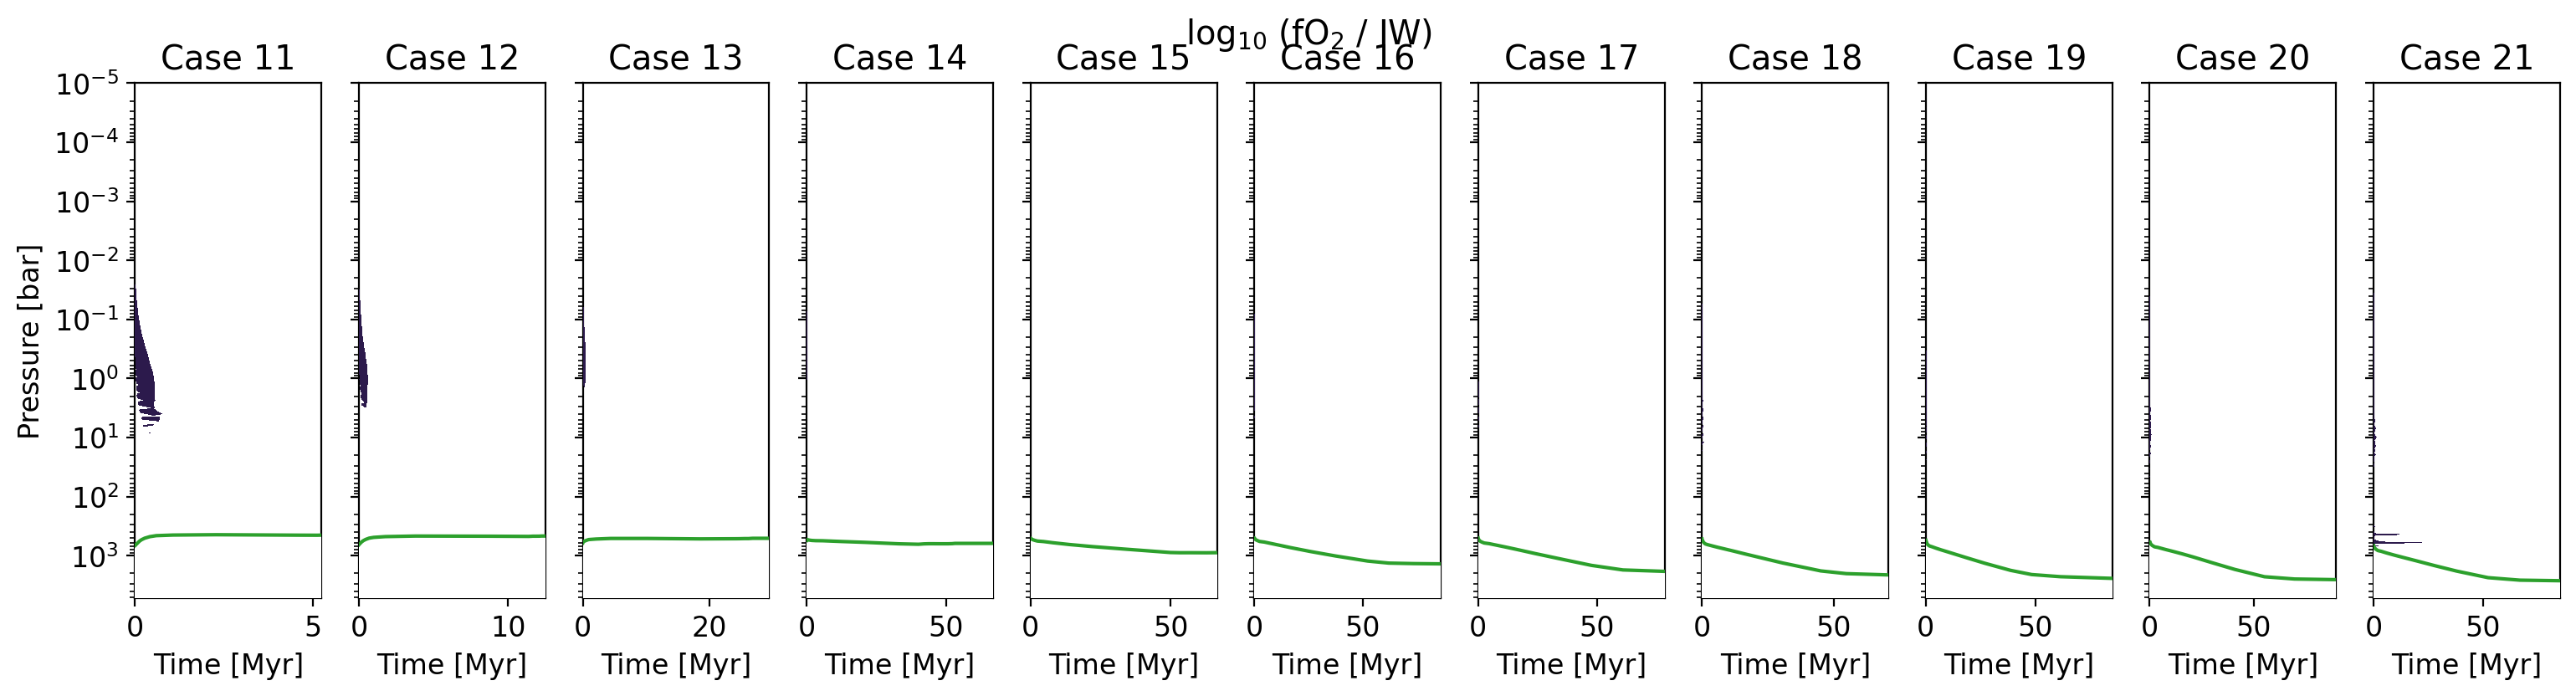

In [96]:
nax = int(npoints/2)
fig,axs = plt.subplots(1,nax,figsize=(1.7*nax,4), sharey=True)

ymin = 1e-4
ymax = 1e1

itp_points = 110
interpolate = False
logx = False

c = 'tab:red'

iax = -1
for i in idxs_plot:
    iax += 1

    yrs = data[i][0]
    dat = data[i][1]

    psurf = []
    times = []

    pts_xs = []
    pts_ys = []
    pts_zs = []
    for j in range(0,len(yrs)):

        if yrs[j] < 10:
            continue

        # time
        t = yrs[j]/1e6
        times.append(t)

        # pressure array
        y = dat[j]["pl"]*1e-5
        psurf.append(np.amax(y))
        ymax = max(ymax, np.amax(y))

        # z-array
        val = np.abs(dat[j][field])

        # interpolate y and val
        if interpolate:
            itp = PchipInterpolator(y, val)
            y = np.logspace(np.log10(y[2]), np.log10(y[-1]), itp_points)
            val = itp(y)

        # store values
        pts_zs.extend(list(val))
        pts_ys.extend(list(y))
        pts_xs.extend(list(np.ones(len(y))*t))

    pts_xs = np.array(pts_xs)
    pts_ys = np.array(pts_ys)
    pts_zs = np.array(pts_zs)

    pts_zs = np.clip(pts_zs, 1e-1, np.inf)

    ymin = min(ymin, np.amin(pts_ys))

    # binary mask
    mask    = pts_zs > 1e-4
    mask_xs = pts_xs[mask]
    mask_ys = pts_ys[mask]

    axs[iax].plot(times, psurf, color='tab:green', zorder=5)
    axs[iax].fill_between(times, psurf, np.ones(np.shape(psurf))*1e20, color='w', zorder=4)

    if len(np.unique(times)) < 3:
        raise Exception("Cannot make contour plot from only one time sample")

    # axs[iax].scatter(mask_xs, mask_ys, s=5, marker='s', zorder=4)

    if len(pts_xs) > 3:
        axs[iax].tricontourf(pts_xs, pts_ys, pts_zs, zorder=3, cmap=conv_cmap, norm=conv_norm, extend='both')

    axs[iax].set_xlabel("Time [Myr]")
    axs[iax].set_title("Case "+str(i))
    if logx:
        axs[iax].set_xscale("log")
    else:
        axs[iax].set_xlim(left=0, right=np.amax(times))
        # axs[iax].xaxis.set_minor_locator(MultipleLocator(0.5))
        # axs[iax].xaxis.set_major_locator(MultipleLocator(1))

axs[0].set_ylim(top=ymin, bottom=ymax*2)
axs[0].set_yscale("log")
axs[0].set_ylabel("Pressure [bar]")

fig.suptitle(indep_lbl)
plt.show()

for fmt in ["png","pdf"]:
    fig.savefig("output/agni_v_janus/%s/contour_%s.%s"%(pltname,field,fmt),bbox_inches='tight', dpi=300)